In [1]:
import os
import sys
sys.path.append(os.path.join(os.pardir, 'src'))

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm.notebook import tqdm

In [4]:
from CBO.distributions import Normal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [6]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [7]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [9]:
# tf.keras.metrics.SparseCategoricalAccuracy()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [10]:
X_train = tf.stack(list(map(lambda x: x[0], ds_train))).numpy()
y_train = tf.stack(list(map(lambda x: x[1], ds_train))).numpy()

In [11]:
X_val = tf.stack(list(map(lambda x: x[0], ds_test))).numpy()
y_val = tf.stack(list(map(lambda x: x[1], ds_test))).numpy()

In [12]:
parameters = []
for weight in model.trainable_weights:
    parameters.append(tf.reshape(weight, -1))
parameters = tf.concat(parameters, 0)

In [13]:
minimizer, trajectory = train(model, loss, X_train, y_train, n_particles=100, time_horizon=12,
                              optimizer_config = {'alpha': 50, 'sigma': 0.4**0.5, 'dt': 0.1}, initial_distribution=Normal(0, 1),
                              return_trajectory=True, verbose=True, particles_batches=10, dataset_batches=60,
                              X_val=X_val, y_val=y_val)


Timestamp: 6.0, loss: 6.448456764221191, validation loss: 6.288543701171875



Timestamp: 12.0, loss: 6.37419319152832, validation loss: 6.288544178009033



Timestamp: 18.0, loss: 6.37419319152832, validation loss: 6.288544178009033


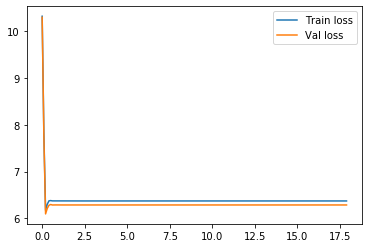

In [14]:
nn_train_loss = NeuralNetworkObjectiveFunction(model, loss, X_train, y_train)
nn_val_loss = NeuralNetworkObjectiveFunction(model, loss, X_val, y_val)

train_losses = []
val_losses = []
timestamps = []
for timestamp, point in tqdm(trajectory.items()):
    params = tf.reshape(point['consensus'], (-1,))
    train_losses.append(nn_train_loss(params))
    val_losses.append(nn_val_loss(params))
    timestamps.append(timestamp)

plt.clf()
plt.plot(timestamps, train_losses, label='Train loss')
plt.plot(timestamps, val_losses, label='Val loss')
plt.legend()
plt.show()